<a href="https://colab.research.google.com/github/techandy42/babilong/blob/main/notebooks/babilong_demo_cohere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM evaluation demo

First install dependences, download and unpack data

In [14]:
!pip install datasets torch cohere nltk seaborn matplotlib python-dotenv

In [15]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [2]:
!git clone https://github.com/booydar/babilong source
!unzip source/data/tasks_1-20_v1-2.zip -d data/

Cloning into 'source'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 61 (delta 24), reused 23 (delta 6), pack-reused 0
Receiving objects: 100% (61/61), 17.45 MiB | 25.74 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Archive:  source/data/tasks_1-20_v1-2.zip
  inflating: data/tasks_1-20_v1-2/LICENSE.txt  
  inflating: data/tasks_1-20_v1-2/README.txt  
  inflating: data/tasks_1-20_v1-2/en-10k/qa10_indefinite-knowledge_test.txt  
  inflating: data/tasks_1-20_v1-2/en-10k/qa10_indefinite-knowledge_train.txt  
  inflating: data/tasks_1-20_v1-2/en-10k/qa11_basic-coreference_test.txt  
  inflating: data/tasks_1-20_v1-2/en-10k/qa11_basic-coreference_train.txt  
  inflating: data/tasks_1-20_v1-2/en-10k/qa12_conjunction_test.txt  
  inflating: data/tasks_1-20_v1-2/en-10k/qa12_conjunction_train.txt  
  inflating: data/tasks_1-20_v1-2/en-10k/qa13_compound-coreference_test.txt  
  inflating: 

In [1]:
import cohere
import asyncio
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset, Dataset
import numpy as np
from transformers import AutoTokenizer
import time
import os
import datasets
from source.babilong_utils import TaskDataset, SentenceSampler, NoiseInjectionDataset

# Choose parameters for evaluation:
* task: babilong task (qa1 - qa10). Use different prompts for each task! You can find our prompts in the Appendix B of our paper
* task_path: path to the file with task data
* message_lengths: list of task lengths to evaluate. It must be less then the LLM's context window
* number_of_samples: number of instances of the task with message_length to evaluate

# Choose LLM
* model: Claude model
    * 'command-r-plus' - Command-R+, context length up to 128k
    * 'command-r' - Command-R, context length up to 128k
* token: your token for Cohere api

# .env
* Create a `.env` file:
```
COHERE_API_KEY=...
```

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

task = 'qa1'
task_path = 'data/tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_test.txt'
message_lengths = [4000]
number_of_samples = 1

model = 'command-r'
tokenizer_model = 'CohereForAI/c4ai-command-r-v01'
token = os.getenv('COHERE_API_KEY')

# Adapt cohere tokenizer api to babilong utils

In [3]:
class Tokenizer():
    def __init__(self, model):
        self.impl_ = AutoTokenizer.from_pretrained(model)

    def __call__(self, inp):
        if isinstance(inp, list):
            result = self.encode_batch(inp)
        else:
            result = self.impl_.encode(inp)
        return {
            'input_ids': result
        }

    def encode(self, inp, add_special_tokens=True):
        return self.impl_.encode(inp, add_special_tokens=add_special_tokens)

    def decode(self, inp, skip_special_tokens=True):
        return self.impl_.decode(inp, skip_special_tokens=skip_special_tokens)

    def encode_batch(self, inp_list, add_special_tokens=True):
        return [self.impl_.encode(inp, add_special_tokens=add_special_tokens) for inp in inp_list]

    def decode_batch(self, inp, skip_special_tokens=True):
        return [self.impl_.decode(tokens, skip_special_tokens=skip_special_tokens) for tokens in inp]

# Choose noise dataset

In this example we use wikitext to generate noise.
To reproduce results from our paper use PG19.

In [4]:
noise_dataset = datasets.load_dataset('wikitext', 'wikitext-2-raw-v1')
#noise_dataset = datasets.load_from_disk("pg19-data-test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Run evaluation loop and save results in .csv format

In [5]:
# create directory to save LLM responses
os.makedirs(task, exist_ok=True)

client = cohere.Client(token)

tokenizer = Tokenizer(tokenizer_model)

task_dataset_test = TaskDataset(task_path)
noise_sampler_test = SentenceSampler(noise_dataset['test'], tokenizer=tokenizer)

for message_length in message_lengths:
    outfile =  f'{task}/msg_{message_length}.csv'
    df = pd.DataFrame({
        'answer': [],
        'commandranswer': [],
        'result': [],
    })

    # create dataset with given message length
    dataset_test = NoiseInjectionDataset(task_dataset=task_dataset_test,
                                         noise_sampler=noise_sampler_test,
                                         tokenizer=tokenizer,
                                         sample_size=message_length)

    # collect Command responses and save them in .csv
    for i, sample in zip(range(number_of_samples), dataset_test):
        facts = sample['facts']
        question = sample['question']
        true_answer = tokenizer.decode(sample['target_tokens'])
        background_text = tokenizer.decode_batch(sample['background_text'])
        query = tokenizer.decode(sample['input_tokens'])

        chat_history = [
            {
                "role": "SYSTEM",
                "message": "You are a intelligent assistant."
            },
        ]
        message = f"""I give you context with the facts about positions of different persons hidden in some random text and a question.
 You need to answer the question based only on the information from the facts.
If a person was in different locations use the latest location to answer the question.\n\n
<example>\n
Charlie went to the hallway. Judith come back to the kitchen. Charlie travelled to balcony. Where is Charlie?\n
Assistant: balcony\n
</example>\n\n
<example>\n
Alan moved to the garage. Charlie went to the beach. Alan went to the shop. Rouse travelled to balcony. Where is Alan?\n
Assistant: shop\n
</example>\n\n
<context>\n
{query}
</context>\n\n
QUESTION: {question}\n
Your answer should be a single word - the most recent location of ’person’ in the question.
Do not write anything afer that."""

        response = client.chat(
            model=model,
            chat_history=chat_history,
            message=message
        )
        command_answer = response.text.strip().lower()

        if command_answer.endswith('.'):
            command_answer = command_answer[:-1]

        print(message_length, i, true_answer, command_answer)

        df.loc[len(df)] = [true_answer, command_answer, true_answer == command_answer]
        df.to_csv(outfile)

tokenizer.json:   0%|          | 0.00/12.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


4000 0 hallway hallway


# Plot evaluation results

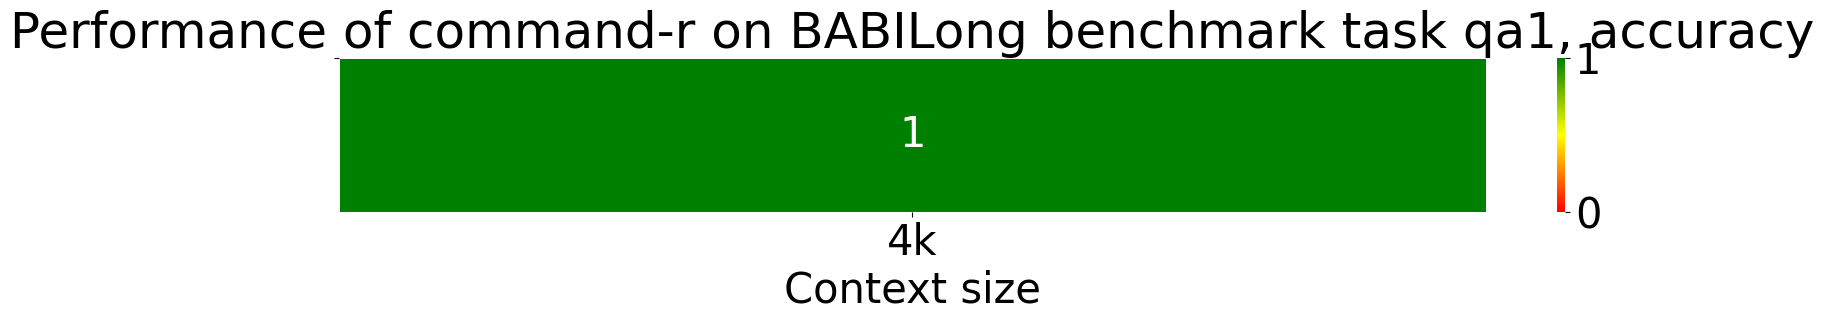

In [6]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

accuracy = np.zeros((1, len(message_lengths)))

for i, msg in enumerate(message_lengths):
    fname = f'{task}/msg_{msg}.csv'
    if not os.path.isfile(fname):
        print('not such file', fname)
        continue
    df = pd.read_csv(fname, index_col=[0])
    last_word = df['commandranswer'].apply(lambda x: x.split(' ')[-1]).apply(lambda x: x.split('\n')[-1])
    score = (last_word == df['answer']).sum()
    accuracy[0, i] = score / len(df)

font = {
    'size'   : 30
}

matplotlib.rc('font', **font)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 2)


cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)
ax = sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=1, annot=True, linewidth=0.5)
ax.set_xlabel('Context size')
labels = [f'{ln}' if ln < 1000 else f'{int(ln / 1000)}k' for ln in message_lengths]
ax.set_xticks(np.array(range(accuracy.shape[1])) + 0.5, labels)
ax.tick_params(axis='y', rotation=90)
ax.set_yticks([0], [''])
ax.set_title('Performance of '+f'{model}'+' on BABILong benchmark task '+f'{task}'+', accuracy')
plt.show()

fig.savefig('fig.pdf', dpi=100)